In [1]:
renv::init('/oak/stanford/groups/agitler/Shared/Shared_Jupyter_Notebook_Analysis/4.1.1-OG/')

In [ ]:
library(dplyr)
library(Seurat)
library(ggplot2)
library(ggrepel)
library(pheatmap)
library(gplots)
library(biomaRt)

# PLEASE NOTE that fribidi must be loaded in the initialization jupyter script for ggrastr to load properly
library(ggrastr)

In [3]:
library(future)
plan("multicore", workers = availableCores())
options(future.globals.maxSize = +Inf)

## Save Directories for Figs and Tables

In [4]:
fig_dir <- '/oak/stanford/groups/agitler/Shared/Matters_Arising/Figure_Panels'
csv_dir <- '/oak/stanford/groups/agitler/Shared/Matters_Arising/CSV_Files'

## Custom Functions

### Volcano plot

In [5]:
make_volcano_plot <- function(data, labeled_pts, labeled_genes=c(), p_val_cutoff=0.05, title, limits=NULL, upper_log2FC_cutoff=0, lower_log2FC_cutoff=0) {
    data <- data %>% 
    mutate(
        Expression = case_when(avg_log2FC >= upper_log2FC_cutoff & p_val_adj <= p_val_cutoff ~ "Up-regulated",
                           avg_log2FC <= lower_log2FC_cutoff & p_val_adj <= p_val_cutoff ~ "Down-regulated",
                           TRUE ~ "Unchanged")
    )


    top <- labeled_pts
   
    top_genes <- bind_rows(
      data %>% 
        filter(Expression == 'Up-regulated') %>% 
        arrange(p_val_adj, desc(abs(avg_log2FC))) %>% 
        head(top),
      data %>% 
        filter(Expression == 'Down-regulated') %>% 
        arrange(p_val_adj, desc(abs(avg_log2FC))) %>% 
        head(top),
      data %>% 
        filter(gene %in% labeled_genes)
    )
    

    x_scale <- max(abs(data$avg_log2FC))
    
    p1 <- ggplot(data, aes(avg_log2FC, -log(p_val_adj,10))) + # -log10 conversion 
        labs(title = title) +
        geom_point(aes(color = Expression), size = 4/5) +
        geom_label_repel(data = top_genes, mapping = aes(avg_log2FC, -log(p_val_adj,10), label = gene),
                        size = 4, max.overlaps=18)+
        xlim(-x_scale,x_scale)+
        xlab(expression("log"[2]*"FC")) + 
        ylab(expression("-log"[10]*"(p adj)")) + 
        scale_color_manual(values = c("dodgerblue3", "gray50", "firebrick3")) + 
        guides(colour = guide_legend(override.aes = list(size=1.5)))  + 
        scale_y_continuous(limits = limits) +
        theme_classic() +
        theme(axis.text = element_text(size = 15), axis.title = element_text(size = 15), plot.title = element_text(size = 18, face = "bold", hjust = 0.5))       
p1  
}

### Function to convert mouse genes to human orthologs

In [6]:
convertMouseGeneList <- function(x){

require("biomaRt")
human = useMart("ensembl", dataset = "hsapiens_gene_ensembl", host = "https://dec2021.archive.ensembl.org/")
mouse = useMart("ensembl", dataset = "mmusculus_gene_ensembl", host = "https://dec2021.archive.ensembl.org/")

humanx = getLDS(attributes = c("mgi_symbol"), filters = "mgi_symbol", values = x , mart = mouse, attributesL = c("hgnc_symbol"), martL = human, uniqueRows=T)

return(humanx)
}

### Function to get proportion intronic reads

In [7]:
get_prop_intronic <- function(with_introns, without_introns, barcodes){

    with_introns_all <- subset(with_introns, cells = barcodes$barcode)
    with_introns_all$barcode <- rownames(with_introns_all@meta.data)
    
    without_introns_all <- subset(without_introns, cells = barcodes$barcode)
    without_introns_all$barcode <- rownames(without_introns_all@meta.data)
    
    prop.intronic <- inner_join(with_introns_all@meta.data, without_introns_all@meta.data, by = "barcode")
    prop.intronic$prop_intronic <- (prop.intronic$nCount_RNA.x - prop.intronic$nCount_RNA.y)/prop.intronic$nCount_RNA.x
    prop.intronic <- inner_join(prop.intronic, barcodes, by = "barcode")
    rownames(prop.intronic) <- prop.intronic$orig.barcode
    prop.intronic <- dplyr::select(prop.intronic, prop_intronic)

return(prop.intronic)
}

## Heatmap - gene expression correlation of motor neurons

### Get Blum (mouse) motor neuron marker genes

In [8]:
blum <- readRDS('/oak/stanford/groups/agitler/Shared/Matters_Arising/Gautier_Yadav/blum.rds')
Idents(blum) <- blum$skeletal_motor_neuron
blum_skeletal_markers <- FindMarkers(blum, ident.1 ="Skeletal Motor Neurons", logfc.threshold = 0.25, max.cells.per.ident = 500, only.pos = TRUE)

### Get mouse skeletal motor neuron marker genes that map to human orthologs

In [9]:
mouse_skeletal_markers <- rownames(blum_skeletal_markers)
mouse_markers_to_human <- convertMouseGeneList(mouse_skeletal_markers) %>% dplyr::select(HGNC.symbol)

### Average gene expression - Blum (mouse) motor neurons 

In [10]:
blum_mns <- readRDS('/oak/stanford/groups/agitler/Shared/Matters_Arising/Gautier_Yadav/blum_mns.rds')

In [ ]:
blum_mn_avg_exp <- AverageExpression(blum_mns, assays = c('RNA'), group.by = "cell_class") %>% as.data.frame()
colnames(blum_mn_avg_exp) <- c("MNs - M (Blum)")

In [12]:
blum_subtype_avg_exp <- AverageExpression(blum_mns, assays = c('RNA'), group.by = "skeletal_subtype") %>% as.data.frame()

In [13]:
blum_subtype_avg_exp[rownames(blum_subtype_avg_exp) %in% c("Mrvi1", "Pard3b", "Plch1"), ] 

,RNA.Alpha,RNA.Gamma,RNA.GammaStar
,<dbl>,<dbl>,<dbl>
Pard3b,0.1675137,6.250306,0.14283703
Plch1,1.8314228,0.125494,3.51762686
Mrvi1,0.6580997,0.000000,0.01632545


In [14]:
colnames(blum_subtype_avg_exp) <- c("Alpha MNs - M (Blum)", "Gamma MNs - M (Blum)", "Gamma* MNs - M (Blum)")

### Average gene expression - Alkaslasi (mouse) motor neurons 

In [15]:
alkaslasi_mns <- readRDS('/oak/stanford/groups/agitler/Shared/Matters_Arising/Gautier_Yadav/alkaslasi_mns.rds')

In [16]:
alkaslasi_mn_avg_exp <- AverageExpression(alkaslasi_mns, assays = c('RNA'), group.by = "cholinergictypes") %>% as.data.frame()
colnames(alkaslasi_mn_avg_exp) <- c("MNs - M (Alkaslasi)")

The following grouping variables have 1 value and will be ignored: cholinergictypes

All grouping variables have 1 value only. Computing across all cells.



In [17]:
alkaslasi_subtype_avg_exp <- AverageExpression(alkaslasi_mns, assays = c('RNA'), group.by = "skeletal_subtype") %>% as.data.frame()

In [18]:
alkaslasi_subtype_avg_exp[rownames(alkaslasi_subtype_avg_exp) %in% c("Mrvi1", "Pard3b", "Plch1"), ] 

,RNA.Alpha,RNA.Gamma,RNA.GammaStar
,<dbl>,<dbl>,<dbl>
Pard3b,0.1004292,4.146690519,0.080430652
Plch1,2.0463519,0.124776386,3.043065231
Mrvi1,0.7038627,0.003577818,0.006333122


In [19]:
colnames(alkaslasi_subtype_avg_exp) <- c("Alpha MNs - M (Alkaslasi)", "Gamma MNs - M (Alkaslasi)", "Gamma* MNs - M (Alkaslasi)")

### Get all detected mouse genes that have a 1:1 mouse ortholog to human ortholog relationship (Blum and Alkaslasi)

In [20]:
mouse_genes_blum <- rownames(blum_mn_avg_exp)
mouse_genes_to_human_blum <- convertMouseGeneList(mouse_genes_blum)

In [21]:
unique_mouse_blum <- mouse_genes_to_human_blum %>% group_by(MGI.symbol) %>% filter(n() == 1)
unique_human_blum <- mouse_genes_to_human_blum %>% group_by(HGNC.symbol) %>% filter(n() == 1)
mouse_genes_to_human_dedup_blum <- inner_join(unique_mouse_blum, unique_human_blum)

Joining, by = c("MGI.symbol", "HGNC.symbol")



In [22]:
mouse_genes_alkaslasi <- rownames(alkaslasi_mn_avg_exp)
mouse_genes_to_human_alkaslasi <- convertMouseGeneList(mouse_genes_alkaslasi)

In [23]:
unique_mouse_alkaslasi <- mouse_genes_to_human_alkaslasi %>% group_by(MGI.symbol) %>% filter(n() == 1)
unique_human_alkaslasi <- mouse_genes_to_human_alkaslasi %>% group_by(HGNC.symbol) %>% filter(n() == 1)
mouse_genes_to_human_dedup_alkaslasi <- inner_join(unique_mouse_alkaslasi, unique_human_alkaslasi)

Joining, by = c("MGI.symbol", "HGNC.symbol")



### Average gene expression - Gautier motor neurons

In [24]:
gautier_mns <- readRDS('/oak/stanford/groups/agitler/Shared/Matters_Arising/Gautier_Yadav/gautier_mns.rds')

In [ ]:
gautier_mn_avg_exp <- AverageExpression(gautier_mns, assays = c('RNA'), group.by = "motor_neuron") %>% as.data.frame()
colnames(gautier_mn_avg_exp) <- c("MNs - H (Gautier)")

In [26]:
gautier_subtype_avg_exp <- AverageExpression(gautier_mns, assays = c('RNA'), group.by = "motor_neuron_subtype") %>% as.data.frame()
colnames(gautier_subtype_avg_exp) <- c("Alpha MNs - H (Gautier)", "Gamma MNs - H (Gautier)")

### Average gene expression - Yadav motor neurons

In [27]:
yadav_mns <- readRDS('/oak/stanford/groups/agitler/Shared/Matters_Arising/Gautier_Yadav/yadav_mns.rds')

In [ ]:
yadav_mn_avg_exp <- AverageExpression(yadav_mns, assays = c('RNA'), group.by = "motor_neuron") %>% as.data.frame()
colnames(yadav_mn_avg_exp) <- c("MNs - H (Yadav)")

### Combine motor neuron average expression profiles from Blum, Alkaslasi, Gautier, and Yadav

In [29]:
blum_mn_avg_exp$MGI.symbol <- rownames(blum_mn_avg_exp)
blum_mouse_to_human <- inner_join(blum_mn_avg_exp, mouse_genes_to_human_dedup_blum, by = "MGI.symbol")

In [30]:
blum_subtype_avg_exp$MGI.symbol <- rownames(blum_subtype_avg_exp)
blum_mouse_to_human <- inner_join(blum_subtype_avg_exp, blum_mouse_to_human, by = c("MGI.symbol"))

In [31]:
alkaslasi_mn_avg_exp$MGI.symbol <- rownames(alkaslasi_mn_avg_exp)
alkaslasi_mouse_to_human <- inner_join(alkaslasi_mn_avg_exp, mouse_genes_to_human_dedup_alkaslasi, by = "MGI.symbol")

In [32]:
alkaslasi_subtype_avg_exp$MGI.symbol <- rownames(alkaslasi_subtype_avg_exp)
alkaslasi_mouse_to_human <- inner_join(alkaslasi_subtype_avg_exp, alkaslasi_mouse_to_human, by = c("MGI.symbol"))

In [33]:
mn_avg_exp_combined <- full_join(blum_mouse_to_human, alkaslasi_mouse_to_human, by = c("MGI.symbol", "HGNC.symbol"))

In [34]:
gautier_mn_avg_exp$HGNC.symbol <- rownames(gautier_mn_avg_exp)
mn_avg_exp_combined <- right_join(gautier_mn_avg_exp, mn_avg_exp_combined, by = "HGNC.symbol")

In [35]:
gautier_subtype_avg_exp$HGNC.symbol <- rownames(gautier_subtype_avg_exp)
mn_avg_exp_combined <- right_join(gautier_subtype_avg_exp, mn_avg_exp_combined, by = "HGNC.symbol")

In [36]:
yadav_mn_avg_exp$HGNC.symbol <- rownames(yadav_mn_avg_exp)
mn_avg_exp_combined <- right_join(yadav_mn_avg_exp, mn_avg_exp_combined, by = "HGNC.symbol")

In [37]:
# Set remaining NA to 0
mn_avg_exp_combined[is.na(mn_avg_exp_combined)] = 0
mn_avg_exp_combined <- dplyr::select(mn_avg_exp_combined, -MGI.symbol)

In [38]:
# Only keep mouse marker genes that mapped to human orthologs
mn_marker_avg_exp_combined <- inner_join(mn_avg_exp_combined, mouse_markers_to_human, by = "HGNC.symbol")

In [39]:
row.names(mn_marker_avg_exp_combined) <- mn_marker_avg_exp_combined$HGNC.symbol
mn_marker_avg_exp_combined <- dplyr::select(mn_marker_avg_exp_combined, -HGNC.symbol)

### Figure 2B

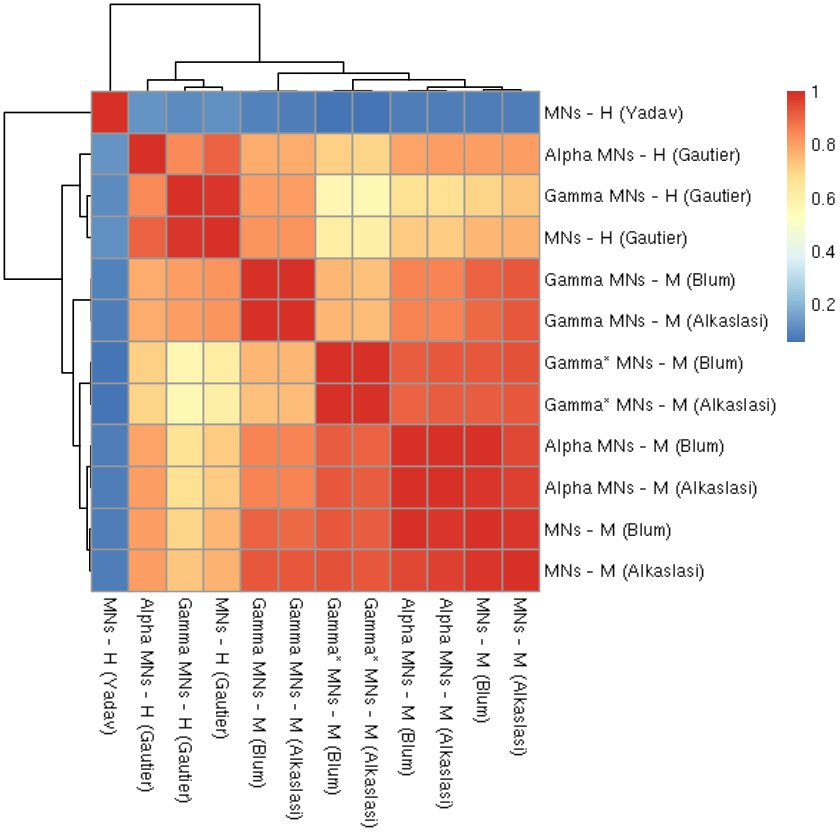

In [40]:
pheatmap(cor(as.matrix(mn_marker_avg_exp_combined)))

In [41]:
pheatmap(cor(as.matrix(mn_marker_avg_exp_combined)), filename = paste(fig_dir, 'gex_correlation_mns_heatmap.pdf', sep='/'), cellwidth = 15, cellheight = 15, fontsize = 14)

## lncRNA analysis

In [42]:
ensembl <- useMart(biomart = "ENSEMBL_MART_ENSEMBL",dataset="hsapiens_gene_ensembl")
lncrna <- getBM(attributes= c('hgnc_symbol'),
                 filters = "biotype",
                 value = 'lncRNA',
                 mart = ensembl)

### Gautier

In [43]:
gautier_neurons <- readRDS(file = '/oak/stanford/groups/agitler/Shared/Matters_Arising/Gautier_Yadav/gautier_neurons.rds')

In [44]:
Idents(gautier_neurons) <- gautier_neurons$motor_neuron
# min.pct=0.1 to select genes that are expressed in at least 10% of motor neurons or other neurons
gautier_mn_markers <- FindMarkers(gautier_neurons, ident.1 = "Motor Neurons", ident.2 = "Other Neurons", logfc.threshold=0, min.pct=0.1, max.cells.per.ident = 40)

In [45]:
gautier_mn_markers$hgnc_symbol <- rownames(gautier_mn_markers)
gautier_mn_lncrna_markers <- inner_join(gautier_mn_markers, lncrna, by = "hgnc_symbol")
gautier_mn_lncrna_markers$gene <- gautier_mn_lncrna_markers$hgnc_symbol

### Figure 2C (left)

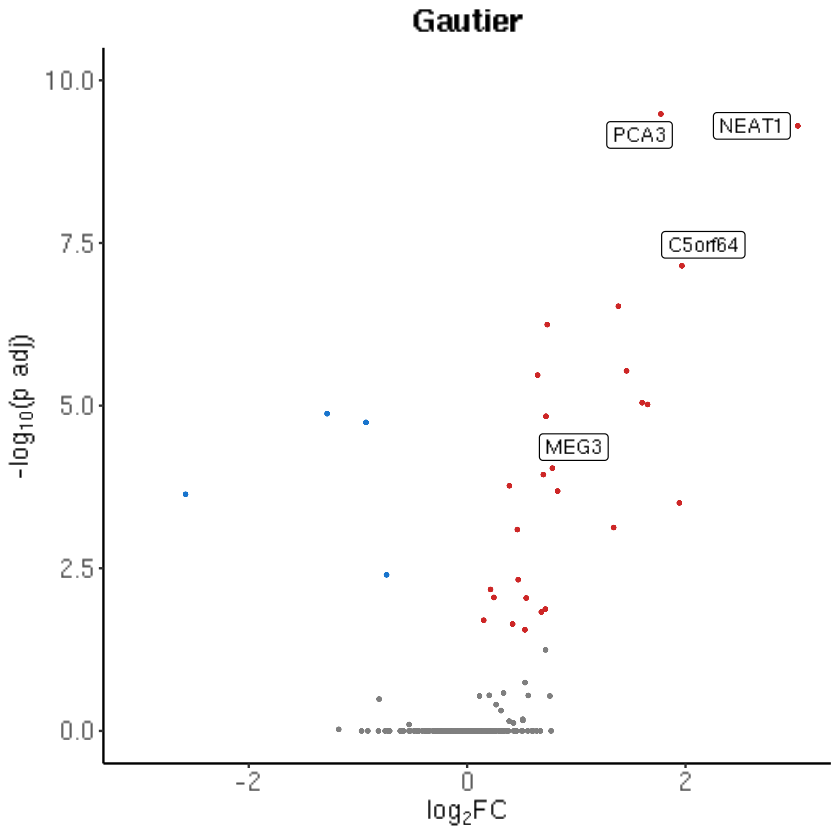

In [46]:
gautier_mn_lncrna_volcano_plot <- make_volcano_plot(gautier_mn_lncrna_markers, 0, p_val_cutoff = 0.05, labeled_genes=c('PCA3', 'NEAT1', 'C5orf64', 'MEG3'), title = "Gautier", limits = c(0,10))
gautier_mn_lncrna_volcano_plot <- rasterize(gautier_mn_lncrna_volcano_plot, layers="Point", dpi=500) + NoLegend()
gautier_mn_lncrna_volcano_plot

In [47]:
ggsave(gautier_mn_lncrna_volcano_plot, filename = paste(fig_dir, 'gautier_mn_lncrna_volcano_plot.svg', sep='/'), device='svg', width = 3.4, height = 4.698, units = "in")

### Table S3

In [48]:
gautier_mn_lncrna_table <- gautier_mn_lncrna_markers
rownames(gautier_mn_lncrna_table) <- gautier_mn_lncrna_table$gene
gautier_mn_lncrna_table <- dplyr::select(gautier_mn_lncrna_table, -hgnc_symbol, -gene)

write.csv(gautier_mn_lncrna_table, file=paste(csv_dir, 'Table S3.csv', sep='/'))

### Yadav

In [49]:
yadav_neurons <- readRDS(file = '/oak/stanford/groups/agitler/Shared/Matters_Arising/Gautier_Yadav/yadav_neurons.rds')

In [50]:
Idents(yadav_neurons) <- yadav_neurons$motor_neuron
# min.pct=0.1 to select genes that are expressed in at least 10% of yadav motor neurons or other neurons
yadav_mn_markers <- FindMarkers(yadav_neurons, ident.1 = "Motor Neurons", ident.2 = "Other Neurons", logfc.threshold=0, min.pct=0.1, max.cells.per.ident = 40)

In [51]:
yadav_mn_markers$hgnc_symbol <- rownames(yadav_mn_markers)
yadav_mn_lncrna_markers <- inner_join(yadav_mn_markers, lncrna, by = "hgnc_symbol")
yadav_mn_lncrna_markers$gene <- yadav_mn_lncrna_markers$hgnc_symbol

### Figure 2C (right)

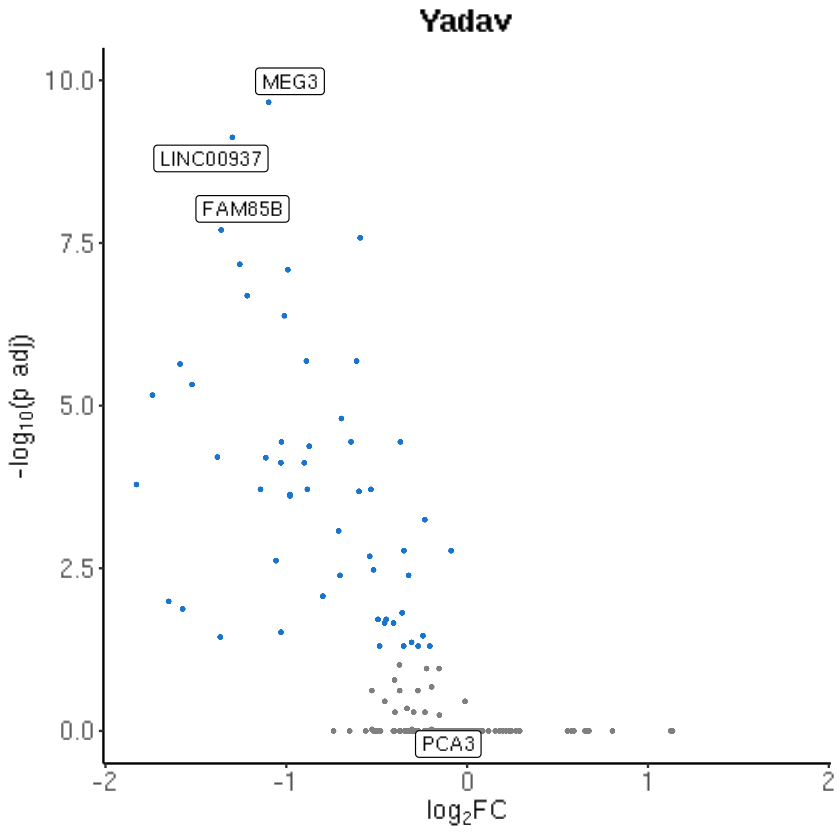

In [52]:
yadav_mn_lncrna_volcano_plot <- make_volcano_plot(yadav_mn_lncrna_markers, 3, p_val_cutoff = 0.05, labeled_genes=c('PCA3'), title = "Yadav", limits = c(0,10))
yadav_mn_lncrna_volcano_plot <- rasterize(yadav_mn_lncrna_volcano_plot, layers="Point", dpi=500) + NoLegend()
yadav_mn_lncrna_volcano_plot

In [53]:
ggsave(yadav_mn_lncrna_volcano_plot, filename = paste(fig_dir, 'yadav_motoneuron_lncrna_volcano_plot.svg', sep='/'),device='svg', width = 3.4, height = 4.698, units = "in")

### Table S4

In [54]:
yadav_mn_lncrna_table <- yadav_mn_lncrna_markers
rownames(yadav_mn_lncrna_table) <- yadav_mn_lncrna_table$gene
yadav_mn_lncrna_table <- dplyr::select(yadav_mn_lncrna_table, -hgnc_symbol, -gene)

write.csv(yadav_mn_lncrna_table, file=paste(csv_dir, 'Table S4.csv', sep='/'))

## Intronic read analysis

### Gautier

### Figure 2D (left)

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.



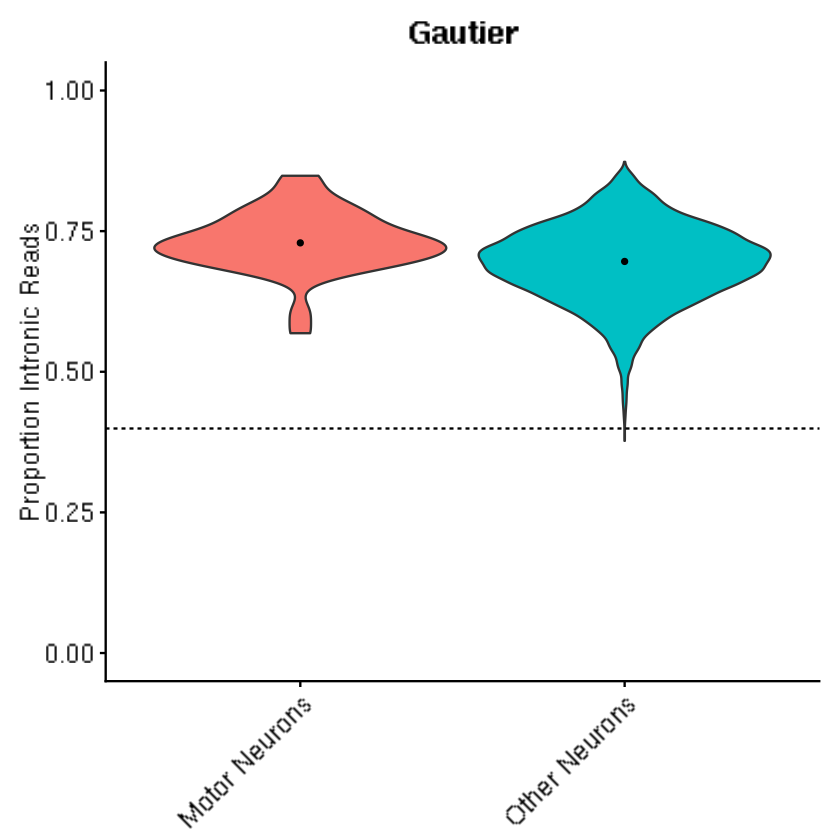

In [55]:
gautier_intronic <- VlnPlot(gautier_neurons, group.by = "motor_neuron", features = "prop_intronic", pt.size = 0) + 
  labs(title = "Gautier", y = "Proportion Intronic Reads") + NoLegend() + FontSize(
  x.text = 15,
  y.text = 15,
  y.title = 15,
  main = 18,
) + scale_y_continuous(limits = c(0,1)) + stat_summary(fun = median, geom='point', size = 1) + theme(axis.title.x = element_blank()) & geom_hline(linetype = "dashed", yintercept = 0.4)

gautier_intronic

In [56]:
ggsave(gautier_intronic, filename = paste(fig_dir, 'gautier_intronic.svg', sep='/'), device='svg', width = 3.4, height = 5.5, units = "in")

In [57]:
filter(gautier_neurons@meta.data, motor_neuron == "Motor Neurons") %>% {median(.$prop_intronic)}

[1] 0.7291398

In [58]:
filter(gautier_neurons@meta.data, motor_neuron == "Other Neurons") %>% {median(.$prop_intronic)}

[1] 0.6961284

#### Save Object

In [59]:
saveRDS(gautier_neurons, file = '/oak/stanford/groups/agitler/Shared/Matters_Arising/Gautier_Yadav/gautier_prop_intronic_neurons.rds')

### Yadav

### Add intronic read proportion to Yadav data

#### Get barcodes by orig.ident

In [60]:
yadav <- readRDS(file = '/oak/stanford/groups/agitler/Olivia/Single_cell/Gautier_Yadav/yadav.rds')

In [61]:
yadav_barcodes <- yadav
yadav_barcodes$barcode <- rownames(yadav_barcodes@meta.data)
yadav_barcodes@meta.data <- yadav_barcodes@meta.data %>% mutate(barcode = stringr::str_remove(barcode, "_.+"))

#### Note: could not find data for Tsai1A, so those data are not included in the subsequent analysis

In [62]:
H1_barcodes <- yadav_barcodes@meta.data %>% dplyr::filter(orig.ident == "H1") %>% dplyr::select(barcode)
H1_barcodes$orig.barcode <- rownames(H1_barcodes)

In [63]:
H4_barcodes <- yadav_barcodes@meta.data %>% dplyr::filter(orig.ident == "H4") %>% dplyr::select(barcode)
H4_barcodes$orig.barcode <- rownames(H4_barcodes)

In [64]:
H5_barcodes <- yadav_barcodes@meta.data %>% dplyr::filter(orig.ident == "H5") %>% dplyr::select(barcode)
H5_barcodes$orig.barcode <- rownames(H5_barcodes)

In [65]:
H6B_barcodes <- yadav_barcodes@meta.data %>% dplyr::filter(orig.ident == "H6B") %>% dplyr::select(barcode)
H6B_barcodes$orig.barcode <- rownames(H6B_barcodes)

In [66]:
H7B_barcodes <- yadav_barcodes@meta.data %>% dplyr::filter(orig.ident == "H7B") %>% dplyr::select(barcode)
H7B_barcodes$orig.barcode <- rownames(H7B_barcodes)

In [67]:
Tsai1B_barcodes <- yadav_barcodes@meta.data %>% dplyr::filter(orig.ident == "Tsai1B") %>% dplyr::select(barcode)
Tsai1B_barcodes$orig.barcode <- rownames(Tsai1B_barcodes)

In [68]:
Tsai2_barcodes <- yadav_barcodes@meta.data %>% dplyr::filter(orig.ident == "Tsai2") %>% dplyr::select(barcode)
Tsai2_barcodes$orig.barcode <- rownames(Tsai2_barcodes)

#### Load data analyzed with and without including intronic reads

In [69]:
H1_with_introns <- Read10X('/oak/stanford/groups/agitler/Olivia/single_cell_data/10X_analyzed/Yadav/H1_with_introns/outs/raw_feature_bc_matrix') %>% CreateSeuratObject()
H1_without_introns <- Read10X('/oak/stanford/groups/agitler/Olivia/single_cell_data/10X_analyzed/Yadav/H1_without_introns/outs/raw_feature_bc_matrix') %>% CreateSeuratObject()

In [70]:
H4_with_introns <- Read10X('/oak/stanford/groups/agitler/Olivia/single_cell_data/10X_analyzed/Yadav/H4_with_introns/outs/raw_feature_bc_matrix') %>% CreateSeuratObject()
H4_without_introns <- Read10X('/oak/stanford/groups/agitler/Olivia/single_cell_data/10X_analyzed/Yadav/H4_without_introns/outs/raw_feature_bc_matrix') %>% CreateSeuratObject()

In [71]:
H5_with_introns <- Read10X('/oak/stanford/groups/agitler/Olivia/single_cell_data/10X_analyzed/Yadav/H5_with_introns/outs/raw_feature_bc_matrix') %>% CreateSeuratObject()
H5_without_introns <- Read10X('/oak/stanford/groups/agitler/Olivia/single_cell_data/10X_analyzed/Yadav/H5_without_introns/outs/raw_feature_bc_matrix') %>% CreateSeuratObject()

In [72]:
H6B_with_introns <- Read10X('/oak/stanford/groups/agitler/Olivia/single_cell_data/10X_analyzed/Yadav/H6B_with_introns/outs/raw_feature_bc_matrix') %>% CreateSeuratObject()
H6B_without_introns <- Read10X('/oak/stanford/groups/agitler/Olivia/single_cell_data/10X_analyzed/Yadav/H6B_without_introns/outs/raw_feature_bc_matrix') %>% CreateSeuratObject()

In [73]:
H7B_with_introns <- Read10X('/oak/stanford/groups/agitler/Olivia/single_cell_data/10X_analyzed/Yadav/H7B_with_introns/outs/raw_feature_bc_matrix') %>% CreateSeuratObject()
H7B_without_introns <- Read10X('/oak/stanford/groups/agitler/Olivia/single_cell_data/10X_analyzed/Yadav/H7B_without_introns/outs/raw_feature_bc_matrix') %>% CreateSeuratObject()

In [74]:
Tsai1B_with_introns <- Read10X('/oak/stanford/groups/agitler/Olivia/single_cell_data/10X_analyzed/Yadav/Tsai1B_with_introns/outs/raw_feature_bc_matrix') %>% CreateSeuratObject()
Tsai1B_without_introns <- Read10X('/oak/stanford/groups/agitler/Olivia/single_cell_data/10X_analyzed/Yadav/Tsai1B_without_introns/outs/raw_feature_bc_matrix') %>% CreateSeuratObject()

In [75]:
Tsai2_with_introns <- Read10X('/oak/stanford/groups/agitler/Olivia/single_cell_data/10X_analyzed/Yadav/Tsai2_with_introns/outs/raw_feature_bc_matrix') %>% CreateSeuratObject()
Tsai2_without_introns <- Read10X('/oak/stanford/groups/agitler/Olivia/single_cell_data/10X_analyzed/Yadav/Tsai2_without_introns/outs/raw_feature_bc_matrix') %>% CreateSeuratObject()

#### Get proportion of intron-containing reads and add as meta data

In [76]:
H1_prop_intronic <- get_prop_intronic(H1_with_introns, H1_without_introns, H1_barcodes)
H4_prop_intronic <- get_prop_intronic(H4_with_introns, H4_without_introns, H4_barcodes)
H5_prop_intronic <- get_prop_intronic(H5_with_introns, H5_without_introns, H5_barcodes)
H6B_prop_intronic <- get_prop_intronic(H6B_with_introns, H6B_without_introns, H6B_barcodes)
H7B_prop_intronic <- get_prop_intronic(H7B_with_introns, H7B_without_introns, H7B_barcodes)
Tsai1B_prop_intronic <- get_prop_intronic(Tsai1B_with_introns, Tsai1B_without_introns, Tsai1B_barcodes)
Tsai2_prop_intronic <- get_prop_intronic(Tsai2_with_introns, Tsai2_without_introns, Tsai2_barcodes)

In [77]:
prop_intronic_combo <- dplyr::bind_rows(H1_prop_intronic, H4_prop_intronic) %>% dplyr::bind_rows(H5_prop_intronic) %>% dplyr::bind_rows(H6B_prop_intronic) %>% dplyr::bind_rows(H7B_prop_intronic) %>% dplyr::bind_rows(Tsai1B_prop_intronic) %>% dplyr::bind_rows(Tsai2_prop_intronic)

In [78]:
yadav_wo_Tsai1A <- subset(yadav, subset = orig.ident != "Tsai1A")

In [79]:
yadav_prop_intronic <- AddMetaData(yadav_wo_Tsai1A, prop_intronic_combo)

In [80]:
yadav_prop_intronic_neurons <- subset(yadav_prop_intronic, subset = top_level_annotation == "Neurons")

In [81]:
yadav_prop_intronic_neurons$motor_neuron <- ifelse(yadav_prop_intronic_neurons$subtype_annotation == "Motoneurons", yes = "Motor Neurons", no = "Other Neurons")

### Figure 2D (right)

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.



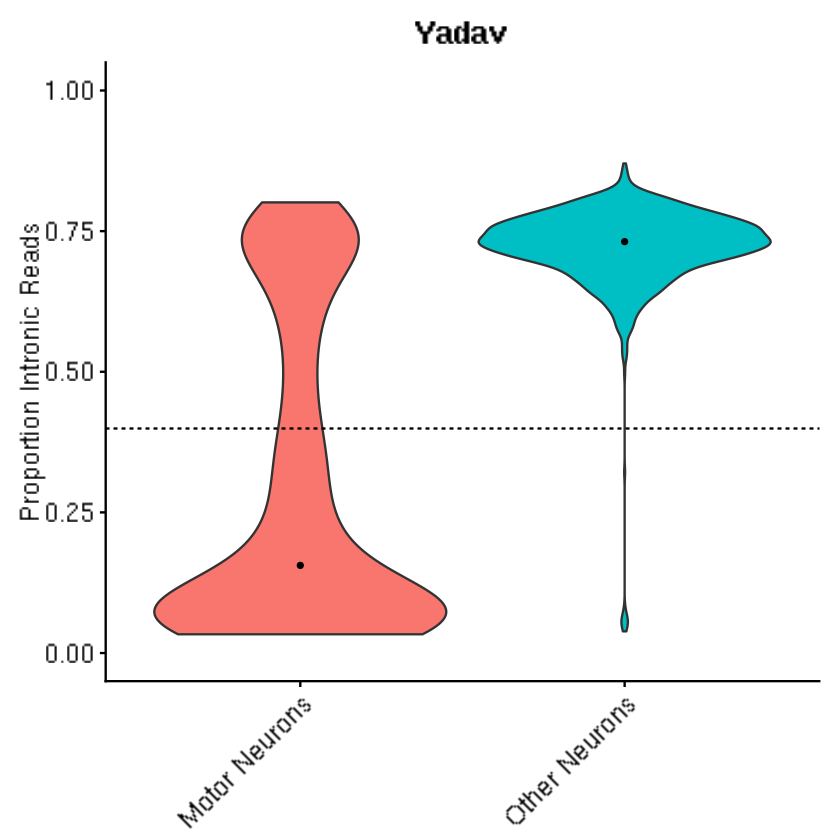

In [82]:
yadav_intronic <- VlnPlot(yadav_prop_intronic_neurons, group.by = "motor_neuron", features = "prop_intronic", pt.size = 0) + 
  labs(title = "Yadav", y = "Proportion Intronic Reads") + NoLegend() + FontSize(
  x.text = 15,
  y.text = 15,
  y.title = 15,
  main = 18,
) + scale_y_continuous(limits = c(0,1)) + stat_summary(fun = median, geom='point', size = 1) + theme(axis.title.x = element_blank()) & geom_hline(linetype = "dashed", yintercept = 0.4)

yadav_intronic

In [83]:
ggsave(yadav_intronic, filename = paste(fig_dir, 'yadav_intronic.svg', sep='/'), device='svg', width = 3.4, height = 5.5, units = "in")

In [84]:
filter(yadav_prop_intronic_neurons@meta.data, motor_neuron == "Motor Neurons") %>% {median(.$prop_intronic)}

[1] 0.1558029

In [85]:
filter(yadav_prop_intronic_neurons@meta.data, motor_neuron == "Other Neurons") %>% {median(.$prop_intronic)}

[1] 0.7313532

#### Save Objects

In [86]:
saveRDS(yadav_prop_intronic, file = '/oak/stanford/groups/agitler/Shared/Matters_Arising/Gautier_Yadav/yadav_prop_intronic.rds')
saveRDS(yadav_prop_intronic_neurons, file = '/oak/stanford/groups/agitler/Shared/Matters_Arising/Gautier_Yadav/yadav_prop_intronic_neurons.rds')

## Volcano plot - low vs. high intronic Yadav MNs

### Split motoneurons into high and low percentage intronic reads (40% cutoff)

In [87]:
yadav_prop_intronic_mns <- subset(yadav_prop_intronic_neurons, subset = motor_neuron == "Motor Neurons")
yadav_prop_intronic_mns$intronic <- ifelse(yadav_prop_intronic_mns$prop_intronic >= 0.4, yes = "High", no = "Low")

In [88]:
Idents(yadav_prop_intronic_mns) <- yadav_prop_intronic_mns$intronic
yadav_intronic_markers <-  FindMarkers(yadav_prop_intronic_mns, ident.1 = "Low", ident.2='High', logfc.threshold=0, min.pct=0,  max.cells.per.ident = 365)

### Table S5

In [89]:
write.csv(yadav_intronic_markers, file=paste(csv_dir, 'Table S5.csv', sep='/'))

### Figure 2E

In [90]:
yadav_intronic_markers$gene <- rownames(yadav_intronic_markers)
rownames(yadav_intronic_markers) <- NULL

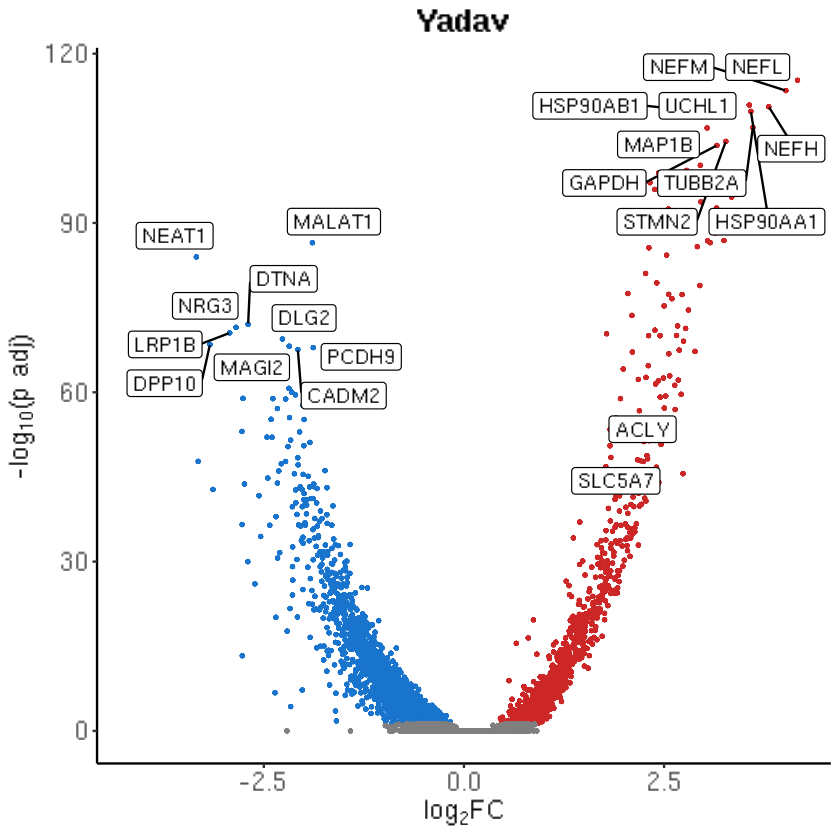

In [91]:
yadav_intronic_volcano_plot <- make_volcano_plot(yadav_intronic_markers, 10, labeled_genes = c('SLC5A7', 'ACLY'), title = "Yadav") 
yadav_intronic_volcano_plot <- rasterize(yadav_intronic_volcano_plot, layers="Point", dpi=500) + NoLegend()
yadav_intronic_volcano_plot

In [92]:
ggsave(yadav_intronic_volcano_plot, filename = paste(fig_dir, 'yadav_intronic_volcano_plot.svg', sep='/'),device='svg', width = 6.4, height = 4.848, units = "in")

#### Save Object

In [93]:
saveRDS(yadav_prop_intronic_mns, file = '/oak/stanford/groups/agitler/Shared/Matters_Arising/Gautier_Yadav/yadav_prop_intronic_mns.rds')

## Volcano plot - high intronic Yadav MNs vs. other neurons

In [94]:
yadav_high_intronic <- subset(x = yadav_prop_intronic_neurons, subset = prop_intronic >= 0.4)

In [95]:
Idents(yadav_high_intronic) <- yadav_high_intronic$motor_neuron
table(yadav_high_intronic$motor_neuron)


Motor Neurons Other Neurons 
          365          1587 

In [96]:
yadav_high_intronic_markers <-  FindMarkers(yadav_high_intronic, ident.1 = 'Motor Neurons', ident.2 = 'Other Neurons', logfc.threshold=0, min.pct=0,  max.cells.per.ident = 365)

### Table S6

In [97]:
write.csv(yadav_high_intronic_markers, file=paste(csv_dir, 'Table S6.csv', sep='/'))

### Figure 2F

In [98]:
yadav_high_intronic_markers$gene <- rownames(yadav_high_intronic_markers)
rownames(yadav_high_intronic_markers) <- NULL

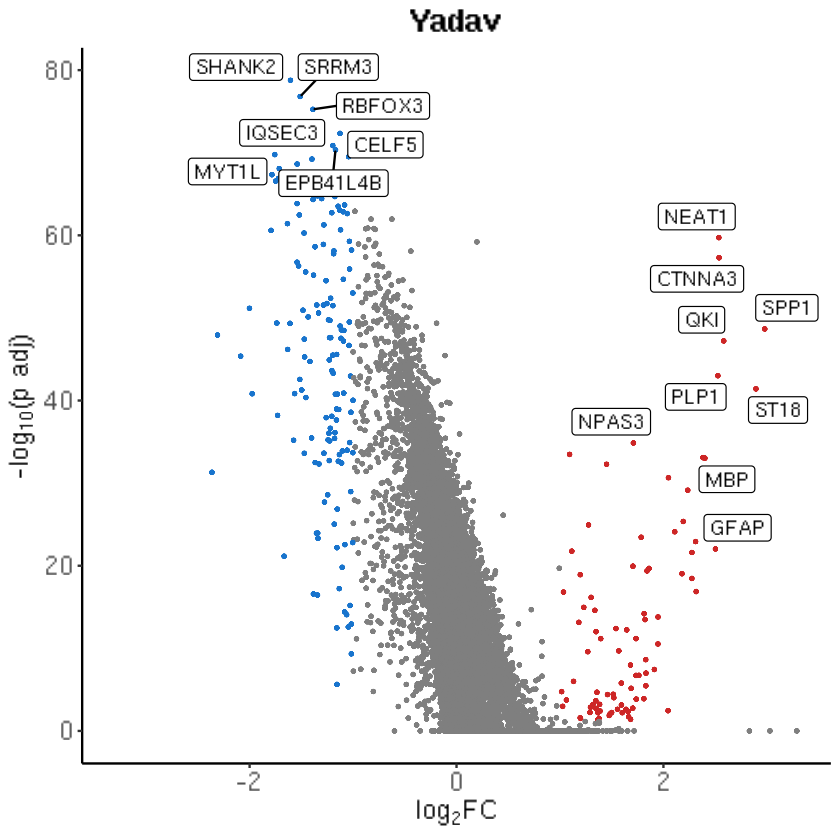

In [99]:
yadav_high_intronic_volcano_plot <- make_volcano_plot(yadav_high_intronic_markers, 7, labeled_genes=c('MBP', 'GFAP'), title = "Yadav", upper_log2FC_cutoff=1, lower_log2FC_cutoff=-1) 
yadav_high_intronic_volcano_plot <- rasterize(yadav_high_intronic_volcano_plot, layers="Point", dpi=500) + NoLegend()
yadav_high_intronic_volcano_plot

In [100]:
ggsave(yadav_high_intronic_volcano_plot, filename = paste(fig_dir, 'yadav_high_intronic_volcano_plot.svg', sep='/'),device='svg', width = 6.4, height = 4.848, units = "in")

## Heatmap - debris gene expression correlation 

In [101]:
yadav_neurons <- readRDS('/oak/stanford/groups/agitler/Shared/Matters_Arising/Gautier_Yadav/yadav_neurons.rds')
gautier_neurons <- readRDS(file = '/oak/stanford/groups/agitler/Shared/Matters_Arising/Gautier_Yadav/gautier_neurons.rds')
gautier_prop_intronic <- readRDS(file = '/oak/stanford/groups/agitler/Shared/Matters_Arising/Gautier_Yadav/gautier_prop_intronic.rds')

### Combine debris cluster 22, gautier_neurons, and yadav_neurons

In [102]:
c22 <- subset(gautier_prop_intronic, seurat_clusters == 22)

In [103]:
c22_avg_exp <- AverageExpression(c22, assays = c('RNA')) %>% as.data.frame()
colnames(c22_avg_exp) <- c("22 - Debris (Gautier)")
c22_avg_exp$genes <- rownames(c22_avg_exp)

The following grouping variables have 1 value and will be ignored: ident

All grouping variables have 1 value only. Computing across all cells.



In [104]:
gautier_neurons_avg_exp <- AverageExpression(gautier_neurons, assays = c('RNA'), group.by = "motor_neuron") %>% as.data.frame()
colnames(gautier_neurons_avg_exp) <- c("Motor Neurons (Gautier)", "Other Neurons (Gautier)")
gautier_neurons_avg_exp$genes <- rownames(gautier_neurons_avg_exp)

In [105]:
yadav_neurons_avg_exp <- AverageExpression(yadav_neurons, assays = c('RNA'), group.by = "motor_neuron") %>% as.data.frame()
colnames(yadav_neurons_avg_exp) <- c("Motor Neurons (Yadav)", "Other Neurons (Yadav)")
yadav_neurons_avg_exp$genes <- rownames(yadav_neurons_avg_exp)

In [106]:
avg_exp_combo <- full_join(c22_avg_exp, gautier_neurons_avg_exp, by = "genes") %>% full_join(., yadav_neurons_avg_exp, by = "genes")
row.names(avg_exp_combo) <- avg_exp_combo$genes
avg_exp_combo <- dplyr::select(avg_exp_combo, -genes) %>% tidyr::drop_na() %>% filter_all(., any_vars(. != 0))

### Figure S1D

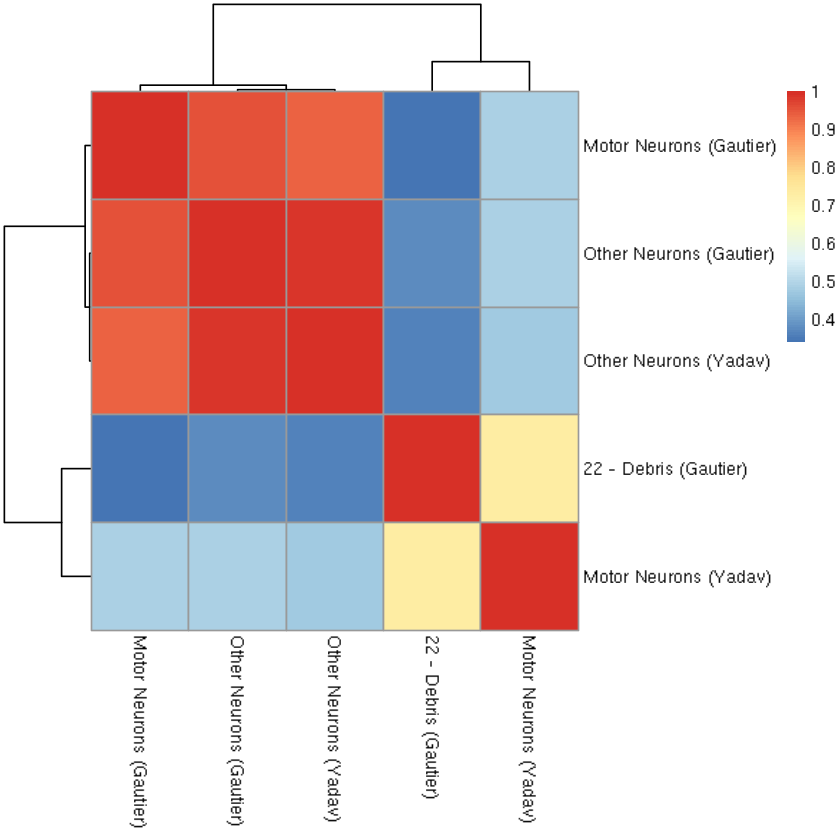

In [107]:
pheatmap(cor(as.matrix(avg_exp_combo)))

In [108]:
pheatmap(cor(as.matrix(avg_exp_combo)), filename = paste(fig_dir, 'debris_neurons_heatmap.pdf', sep='/'), cellwidth = 30, cellheight = 30, fontsize = 14)